In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df=pd.read_csv('bank-full.csv',sep=';')

In [15]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [16]:
df.y=(df.y == 'yes').astype(int)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [19]:
del df['default']
del df['loan']

In [20]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values


## Question 1

In [21]:
numerical = ['age','balance','day','duration', 'campaign','pdays','previous']
categorical = ['job','marital','education','housing','contact','month']

In [25]:
from sklearn.metrics import roc_auc_score

In [28]:
#Balance
roc_auc_score(df_train.y, df_train.balance)

0.5888313805382317

In [29]:
#Day
roc_auc_score(df_train.y, df_train.day)

0.474042117616092

In [30]:
#Duration
roc_auc_score(df_train.y, df_train.duration)

0.8147002759670778

In [31]:
#Previous
roc_auc_score(df_train.y, df_train.previous)

0.5985653242764153

R: Duration


## Question 2

In [32]:
del df_train['y']
del df_val['y']
del df_test['y']

In [33]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [34]:
def train (df, y_train,C=1.0):
    dicts = df[categorical+numerical].to_dict(orient='records')

    dv=DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model=LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [35]:
def predict(df, dv, model):
    dicts = df[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [36]:
dv, model =train(df_train, y_train, C=1.0)

In [37]:
y_pred = predict(df_val,dv, model)

In [41]:
roc_auc_score(y_val, y_pred).round(2)

0.89

R: 0.89

## Question 3

In [45]:
thresholds=np.linspace(0,1,101)

scores = []

for t in thresholds:
    actual_positive = (y_val==1)
    actual_negative = (y_val==0)

    predict_positive = (y_pred >=t)
    predict_negative = (y_pred <t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, precision, recall))

columns = ['treshold','tp','fp','fn','tn','precision','recall']
df_scores = pd.DataFrame(scores,columns=columns)


C:\Users\bruno\AppData\Local\Temp\ipykernel_20052\4236632747.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


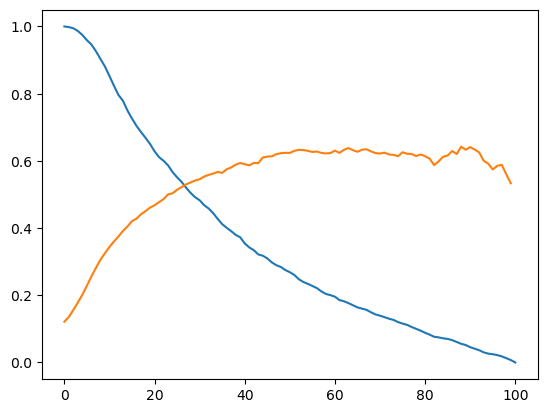

In [48]:
plt.plot(df_scores.recall)
plt.plot(df_scores.precision)

R: 0.265

## Question 4

In [50]:
thresholds=np.linspace(0,1,101)

scores = []

for t in thresholds:
    actual_positive = (y_val==1)
    actual_negative = (y_val==0)

    predict_positive = (y_pred >=t)
    predict_negative = (y_pred <t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1=2*(precision*recall)/(precision+recall)

    scores.append((t, f1))

columns = ['treshold','f1']
df_scores = pd.DataFrame(scores,columns=columns)

C:\Users\bruno\AppData\Local\Temp\ipykernel_20052\2499448855.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


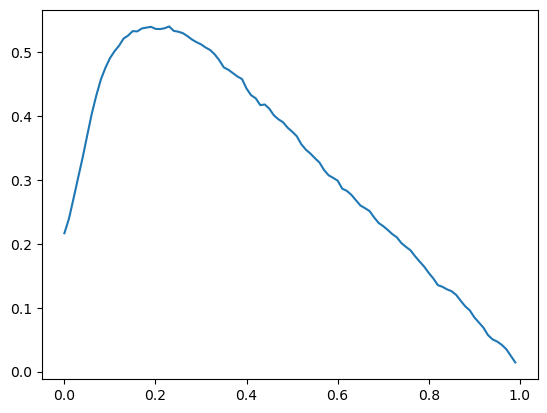

In [53]:
plt.plot(df_scores.treshold,df_scores.f1)

R: 0.22

## Question 5

In [57]:
from sklearn.model_selection import KFold

In [64]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict (df_val,dv,model)

    auc = roc_auc_score(y_val, y_pred)
        
    scores.append(auc)


In [65]:
std = np.std(scores)

In [66]:
std

0.004314489363648151

In [67]:
scores

[0.8873176617242582,
 0.8895015884146665,
 0.8963228470465185,
 0.8970813756352914,
 0.8977563865782126]

R:I would say but 0.004 but it's 0.006

## Question 6

In [68]:
from tqdm.auto import tqdm

In [69]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict (df_val,dv,model)

        auc = roc_auc_score(y_val, y_pred)
        
        scores.append(auc)
    print ('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.844 +- 0.008
C=1 0.894 +- 0.004


R: C=1